# Evo 2 Mech Interp Example Notebook
This notebook is modified for learning/setting it up with the API instead of the local Evo2 implementation

Minimal example of extracting features for an *E. coli* genome chunk and plotting to recreate parts of the main and supplementary figures

In [2]:
import torch
from Bio import SeqIO
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import io, base64, requests, json, zipfile
import os
import numpy as np
import torch
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.set_grad_enabled(False)

/Users/garrettroell/yarrowia_genome_language_modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.autograd.grad_mode.set_grad_enabled(mode=False)

### Define a small Evo2 API client

In [3]:
NVIDIA_API_KEY = os.getenv("NVCF_RUN_KEY") or os.getenv("NVIDIA_API_KEY")
BASE_URL = "https://health.api.nvidia.com/v1/biology"

if NVIDIA_API_KEY is None:
    raise RuntimeError(
        "Missing NVIDIA API key. Set env var NVCF_RUN_KEY or NVIDIA_API_KEY."
    )

HEADERS = {
    "Authorization": f"Bearer {NVIDIA_API_KEY}",
    "Content-Type": "application/json",
}

class Evo2API:
    def __init__(self, model="evo2-7b"):
        self.model = model
        # you no longer need a tokenizer on the client; server handles text->tokens
        self.d_hidden = 4096  # adjust if your model differs

    def _decode_npz(self, b64blob: str) -> dict[str, np.ndarray]:
        """Decode base64-encoded NPZ returned by /forward."""
        npz = np.load(io.BytesIO(base64.b64decode(b64blob)))
        return {k: npz[k] for k in npz.files}

    def forward(self, sequence, output_layers=None, model="evo2-7b", timeout_s=1800, max_polls=120):
        print(f"Using model: {model} to forward")

        if output_layers is None:
            output_layers = ["unembed"]
        elif "unembed" not in output_layers:
            output_layers = ["unembed"] + list(output_layers)

        url = f"{BASE_URL}/arc/{model}/forward"
        payload = {"sequence": sequence, "output_layers": output_layers}

        headers = dict(HEADERS)
        headers.setdefault("Accept", "application/json, application/zip")
        # reduce polling by asking server to hold the connection (if supported)
        headers.setdefault("Prefer", "wait=30")

        # 1) Kick off
        r = requests.post(url, headers=headers, json=payload, timeout=timeout_s)
        print("Received response, status code:", r.status_code)

        # 2) Poll loop for 202 (POST, not GET)
        polls = 0
        reqid = r.headers.get("Nvcf-Reqid")
        while r.status_code == 202:
            polls += 1
            retry_after = int(r.headers.get("Retry-After", 10))
            status_hdr  = r.headers.get("Nvcf-Status")
            print(f"[poll {polls}] 202 Accepted — status={status_hdr}, retry_after={retry_after}s, reqid={reqid}")
            if polls >= max_polls:
                raise TimeoutError(f"Gave up after {polls} polls (last status={status_hdr}).")

            time.sleep(retry_after)

            poll_headers = dict(headers)
            if reqid:
                poll_headers["Nvcf-Reqid"] = reqid

            # Many backends require the SAME payload when polling. Try with payload first.
            r = requests.post(url, headers=poll_headers, json=payload, timeout=timeout_s)
            print("Poll response code:", r.status_code)

            if r.status_code == 405:
                # If the server responds with 405 again, surface allowed methods for debugging
                allow = r.headers.get("Allow")
                raise RuntimeError(f"Polling method not allowed (405). Server Allow={allow}. "
                                f"Keep using POST to /forward with the SAME payload.")

            # Some backends might redirect to a result URL; follow Location if present
            if r.status_code in (303, 302) and "Location" in r.headers:
                url = r.headers["Location"]
                # Usually result endpoints accept GET:
                r = requests.get(url, headers=poll_headers, timeout=timeout_s)
                print("Followed Location, response:", r.status_code)

        # 3) Non-202 → decode
        r.raise_for_status()
        ct = (r.headers.get("Content-Type") or "").lower()
        print("Final Content-Type:", ct)

        def squeeze(x: np.ndarray) -> np.ndarray:
            return x[0] if (isinstance(x, np.ndarray) and x.ndim >= 3 and x.shape[0] == 1) else x

        if "application/zip" in ct or "application/x-zip" in ct or "application/octet-stream" in ct:
            # Outer ZIP → inner JSON → base64 NPZ
            with zipfile.ZipFile(io.BytesIO(r.content), "r") as z:
                names = z.namelist()
                if not names:
                    raise RuntimeError("Empty ZIP in response.")
                inner = z.read(names[0])
            resp = json.loads(inner.decode("utf-8", "replace"))
            if "data" not in resp:
                raise RuntimeError(f"Inner JSON missing 'data'; keys={list(resp.keys())}")
            raw = base64.b64decode(resp["data"])
            npz = np.load(io.BytesIO(raw), allow_pickle=False)
            tensors = {k: npz[k] for k in npz.files}

        elif "application/json" in ct:
            resp = r.json()
            if "data" not in resp:
                raise RuntimeError(f"JSON missing 'data'; keys={list(resp.keys())}")
            raw = base64.b64decode(resp["data"])
            npz = np.load(io.BytesIO(raw), allow_pickle=False)
            tensors = {k: npz[k] for k in npz.files}

        else:
            snippet = r.content[:200]
            raise RuntimeError(f"Unsupported Content-Type: {ct}. First 200 bytes: {snippet!r}")

        logits = tensors.pop("unembed", None)
        if logits is not None:
            logits = squeeze(logits)
        acts = {k: squeeze(v) for k, v in tensors.items()}

        print(f"Got {len(acts)} activation layers: {list(acts.keys())}")
        if logits is not None:
            print("Logits shape:", logits.shape)

        return logits, acts


    def generate(self, prompts, n_tokens=100, temperature=1.0, top_k=4, top_p=1.0,
                enable_logits=False, enable_sampled_probs=False):
        """
        Call Evo2 /generate. `prompts` is a list[str].
        Returns a dict; typical keys: 'sequences', optionally 'logits' or 'sampled_probs'
        """
        url = f"{BASE_URL}/arc/{self.model}/generate"
        payload = {
            "sequences": prompts,
            "num_tokens": n_tokens,
            "temperature": temperature,
            "top_k": top_k,
            "top_p": top_p,
            "enable_logits": enable_logits,
            "enable_sampled_probs": enable_sampled_probs,
        }
        r = requests.post(url, headers=HEADERS, json=payload, timeout=300)
        r.raise_for_status()
        return r.json()
    
# test the forward function
example_seq_short = 'TCTGAAAGGACAGTTTTATTGTAGGTACACATGGCTGCCATTTCAAATGTAACTCACAGCTTGTCCATCAGTCCTTG'
example_seq_long = 'TCTGAAAGGACAGTTTTATTGTAGGTACACATGGCTGCCATTTCAAATGTAACTCACAGCTTGTCCATCAGTCCTTGGAGGTCTTTCTATGAAAGGAGCTTGGTGGCGTCCAAACACCACCCAATGTCCACTTAGAAGTAAGCACCGTGTCTGCCCTGAGCTGACTCCTTTTCCAAGGAAGGGGTTGGATCGCTGAGTGTTTTTCCAGGTGTCTACTTGTTGTTAATTAATAGCAATGACAAAGCAGAAGGTTCATGCGTAGCTCGGCTTTCTGGTATTTGCTGCCCGTTGACCAATGGAAGATAAACCTTTGCCTCAGGTGGCACCACTAGCTGGTTAAGAGGCACTTTGTCCTTTCACCCAGGAGCAAACGCACATCACCTGTGTCCTCATCTGATGGCCCTGGTGTGGGGCACAGTCGTGTTGGCAGGGAGGGAGGTGGGGTTGGTCCCCTTTGTGGGTTTGTTGCGAGGCCGTGTTCCAGCTGTTTCCACAGGGAGCGATTTTCAGCTCCACAGGACACTGCTCCCCAGTTCCTCCTGAGAACAAAAGGGGGCGCTGGGGAGAGGCCACCGTTCTGAGGGCTCACTGTATGTGTTCCAGAATCTCCCCTGCAGACCCCCACTGAGGACGGATCTGAGGAACCGGGCTCTGAAACCTCTGATGCTAAGAGCACTCCAACAGCGGAAGGTGGGCCCCCCTTCAGACGCCCCCTCCATGCCTCCAGCCTGTGCTTAGCCGTGCTTTGAGCCTCCCTCCTGGCTGCATCTGCTGCTCCCCCTGGCTGAGAGATGTGCTCACTCCTTCGGTGCTTTGCAGGACAGCGTGGTGGGAGCTGAGCCTTGCGTCGATGCCTTGCTTGCTGGTGCTGAGTGTGGGCACCTTCATCCCGTGTGTGCTCTGGAGGCAGCCACCCTTGGACAGTCCCGCGCACAGCTCCACAAAGCCCCGCTCCATACGATTGTCCTCCCACACCCCCTTCAAAAGCCCCCTCCTCTCT'


client = Evo2API(model="evo2-7b")
logits, short_acts = client.forward(example_seq_short, output_layers=["blocks.26.mlp.l3"], model="evo2-7b")
print(short_acts["blocks.26.mlp.l3.output"].shape)

logits, long_acts = client.forward(example_seq_long, output_layers=["blocks.26.mlp.l3"], model="evo2-7b")
print(long_acts["blocks.26.mlp.l3.output"].shape)

Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/json
Got 2 activation layers: ['blocks.26.mlp.l3.output', 'unembed.output']
(77, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.mlp.l3.output', 'unembed.output']
(1000, 4096)


## Load SAE

In [4]:
class BatchTopKTiedSAE(torch.nn.Module):
    def __init__(
        self,
        d_in, # model dimension (4096 in Evo2-7B)
        d_hidden, # hidden dimension (with 8x expansion factor = 32768)
        k, # number of top active features to keep per sample
        device, 
        dtype,
        tiebreaker_epsilon: float = 1e-6
        ):
        super().__init__()
        # create internal variables to hold main hyperparameters
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.k = k
        
        # create a random weight matrix with normalized columns
        W_mat = torch.randn((d_in, d_hidden))
        W_mat = 0.1 * W_mat / torch.linalg.norm(W_mat, dim=0, ord=2, keepdim=True)
        self.W = torch.nn.Parameter(W_mat)

        # create bias parameters
        self.b_enc = torch.nn.Parameter(torch.zeros(self.d_hidden))
        self.b_dec = torch.nn.Parameter(torch.zeros(self.d_in))
        self.device = device
        self.dtype = dtype
        self.tiebreaker_epsilon = tiebreaker_epsilon
        self.tiebreaker = torch.linspace(0, tiebreaker_epsilon, d_hidden)
        self.to(self.device, self.dtype)
        

    # Applies the linear transformation xW + b_{enc}.
    # No activation yet — this is the pre-activation stage.
    def encoder_pre(self, x):
        return x @ self.W + self.b_enc

    # Applies ReLU, then keeps only the top-k activations per sample.
    def encode(self, x, tiebreak=False):
        f = torch.nn.functional.relu(self.encoder_pre(x))
        return self._batch_topk(f, self.k, tiebreak=tiebreak)
    
    # 
    def _batch_topk(self, f, k, tiebreak=False):
        from math import prod

        if tiebreak:  # break ties in feature order for determinism
            f += self.tiebreaker.broadcast_to(f)
        *input_shape, _ = f.shape  # handle higher-dim tensors (e.g. from sequence input)
        numel = k * prod(input_shape)
        f_topk = torch.topk(f.flatten(), numel, dim=-1)
        f_topk = torch.zeros_like(f.flatten()).scatter(-1, f_topk.indices, f_topk.values).reshape(f.shape)
        return f_topk

    def decode(self, f):
        return f @ self.W.T + self.b_dec

    def forward(self, x):
        f = self.encode(x)
        return self.decode(f), f

def load_topk_sae(
    sae_path: str,
    d_hidden: int,
    device: str,
    dtype: torch.dtype,
    expansion_factor: int = 16,
):
    sae_dict = torch.load(sae_path, weights_only=True, map_location="cpu")

    new_dict = {}
    for key, item in sae_dict.items():
        new_dict[key.replace("_orig_mod.", "").replace("module.", "")] = item

    sae_dict = new_dict

    cached_sae = BatchTopKTiedSAE(
        d_hidden,
        d_hidden * expansion_factor,
        64, # this is a topk64 sae
        device,
        dtype,
    )
    cached_sae.load_state_dict(sae_dict)

    return cached_sae

In [5]:
file_path = hf_hub_download(
    repo_id=f"Goodfire/Evo-2-Layer-26-Mixed",
    filename=f"sae-layer26-mixed-expansion_8-k_64.pt",
    repo_type="model"
)
file_path

'/Users/garrettroell/.cache/huggingface/hub/models--Goodfire--Evo-2-Layer-26-Mixed/snapshots/a02b08a876b112d1c5da172e57a59e2bc76b1d70/sae-layer26-mixed-expansion_8-k_64.pt'

In [6]:
model = Evo2API(model="evo2-7b")  # or your hosted model name
device = "mps"  # use 
dtype = torch.bfloat16

topk_sae = load_topk_sae(
    file_path,
    d_hidden=model.d_hidden,
    device=device,
    dtype=dtype,
    expansion_factor=8
)
SAE_LAYER_NAME = "blocks.26.mlp.l3"

## Compute and visualize some features

In [7]:
def get_feature_ts_via_forward(sae, seq, layer_name=SAE_LAYER_NAME):
    print("Calling the forward function for layer:", layer_name)
    # Ask server for this layer’s activations along the full sequence
    logits, acts = model.forward(seq, output_layers=[layer_name])

    print("Acts keys:", list(acts.keys()))

    layer_act = acts[f'{layer_name}.output']  # np.ndarray with shape [T, d_hidden] (expected)

    print("Layer activations shape:", layer_act.shape)
    # Convert to torch and encode
    x = torch.tensor(layer_act, device=device, dtype=dtype)
    feats = sae.encode(x).cpu().detach().float().numpy()  # [T, d_sae]
    return feats

feats = get_feature_ts_via_forward(topk_sae, example_seq_short,layer_name=SAE_LAYER_NAME )
print("Feature shape:", feats.shape)  # [T, d_sae]

Calling the forward function for layer: blocks.26.mlp.l3
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/json
Got 2 activation layers: ['blocks.26.mlp.l3.output', 'unembed.output']
Acts keys: ['blocks.26.mlp.l3.output', 'unembed.output']
Layer activations shape: (77, 4096)
Feature shape: (77, 32768)


In [8]:
# Let's get features for 1 kb of human genome sequence (randomly selected from chr17 GRCh38.p14)
example_seq = 'TCTGAAAGGACAGTTTTATTGTAGGTACACATGGCTGCCATTTCAAATGTAACTCACAGCTTGTCCATCAGTCCTTGGAGGTCTTTCTATGAAAGGAGCTTGGTGGCGTCCAAACACCACCCAATGTCCACTTAGAAGTAAGCACCGTGTCTGCCCTGAGCTGACTCCTTTTCCAAGGAAGGGGTTGGATCGCTGAGTGTTTTTCCAGGTGTCTACTTGTTGTTAATTAATAGCAATGACAAAGCAGAAGGTTCATGCGTAGCTCGGCTTTCTGGTATTTGCTGCCCGTTGACCAATGGAAGATAAACCTTTGCCTCAGGTGGCACCACTAGCTGGTTAAGAGGCACTTTGTCCTTTCACCCAGGAGCAAACGCACATCACCTGTGTCCTCATCTGATGGCCCTGGTGTGGGGCACAGTCGTGTTGGCAGGGAGGGAGGTGGGGTTGGTCCCCTTTGTGGGTTTGTTGCGAGGCCGTGTTCCAGCTGTTTCCACAGGGAGCGATTTTCAGCTCCACAGGACACTGCTCCCCAGTTCCTCCTGAGAACAAAAGGGGGCGCTGGGGAGAGGCCACCGTTCTGAGGGCTCACTGTATGTGTTCCAGAATCTCCCCTGCAGACCCCCACTGAGGACGGATCTGAGGAACCGGGCTCTGAAACCTCTGATGCTAAGAGCACTCCAACAGCGGAAGGTGGGCCCCCCTTCAGACGCCCCCTCCATGCCTCCAGCCTGTGCTTAGCCGTGCTTTGAGCCTCCCTCCTGGCTGCATCTGCTGCTCCCCCTGGCTGAGAGATGTGCTCACTCCTTCGGTGCTTTGCAGGACAGCGTGGTGGGAGCTGAGCCTTGCGTCGATGCCTTGCTTGCTGGTGCTGAGTGTGGGCACCTTCATCCCGTGTGTGCTCTGGAGGCAGCCACCCTTGGACAGTCCCGCGCACAGCTCCACAAAGCCCCGCTCCATACGATTGTCCTCCCACACCCCCTTCAAAAGCCCCCTCCTCTCT'
example_seq = example_seq[:1000]  # trim to 0.5 kb
# feature_ts = get_feature_ts_via_forward(topk_sae, example_seq, layer_name=SAE_LAYER_NAME)
feats_ts = get_feature_ts_via_forward(topk_sae, example_seq, layer_name=SAE_LAYER_NAME)
print("Feature shape:", feats_ts.shape)  # [T, d_sae]

Calling the forward function for layer: blocks.26.mlp.l3
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.mlp.l3.output', 'unembed.output']
Acts keys: ['blocks.26.mlp.l3.output', 'unembed.output']
Layer activations shape: (1000, 4096)
Feature shape: (1000, 32768)


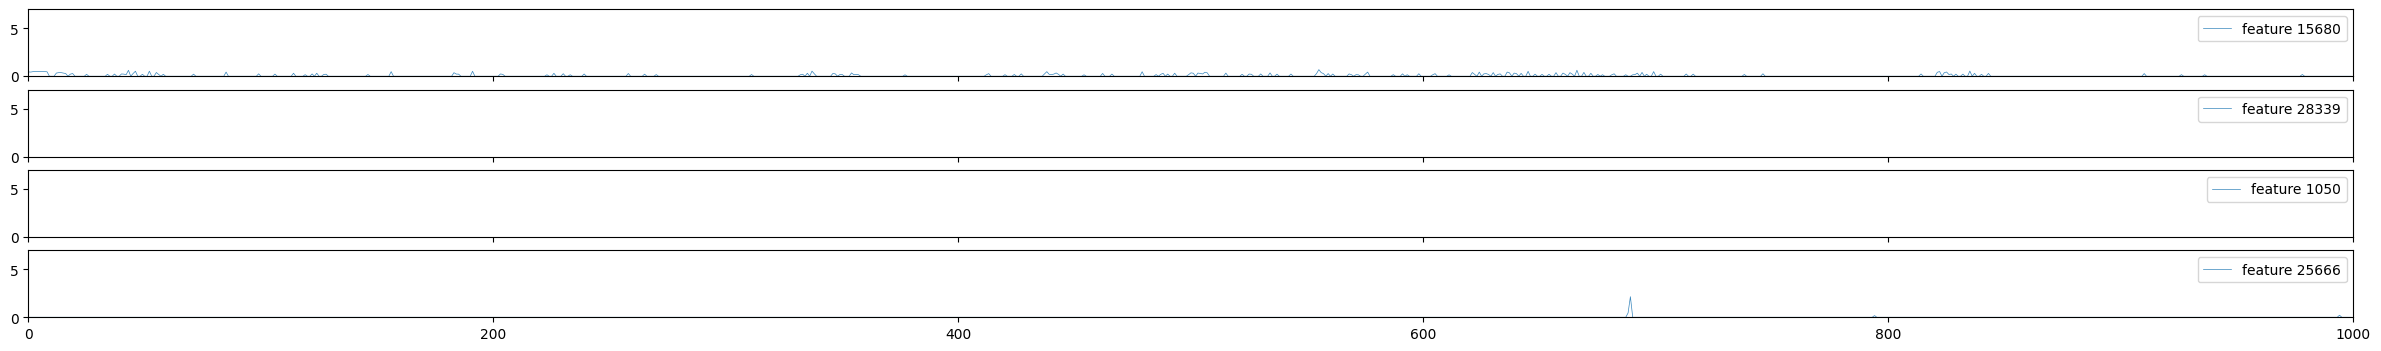

In [9]:
# Next, we plot a few of the features
selected_features = [15680, 28339, 1050, 25666]
fig, axes = plt.subplots(len(selected_features), 1, figsize = (30, 1*len(selected_features)), sharex = True)
for ind, feature in enumerate(selected_features):
    axes[ind].plot(feats_ts[:, feature], lw=0.5, label=f"feature {feature}", alpha = 0.9)
    axes[ind].set_xlim(0, feats_ts.shape[0])
    axes[ind].set_ylim([0, 7]) # just to look nice
    axes[ind].set_yticks([0, 5])
    axes[ind].legend()
plt.show()

## Demo from paper

In [10]:
def find_relevant_gb_annotations(records, window_start, window_size, 
                                valid_features={'CDS', 'gene', 'mobile_element', 'misc_feature', 
                                              'rRNA', 'tRNA', 'ncRNA', 'Regulatory', 'tmRNA'},
                                valid_qualifiers={'gene', 'locus_id', 'product', 'mobile_element_type'}):
    """
    Extract annotations from GenBank records within a specified window.
    
    Args:
        records: List of GenBank records
        window_start: Start position of window (int)
        window_size: Size of window (int)
        valid_features: Set of feature types to include
        valid_qualifiers: Set of qualifiers to extract
    
    Returns:
        List of annotations: [start, end, type, qualifiers_dict]
    """
    window_end = window_start + window_size
    annotations = []
    
    for record in records:
        for feature in record.features:
            # Skip features outside window
            if feature.location.end < window_start or feature.location.start > window_end:
                continue
                
            if feature.type in valid_features:
                # Calculate relative positions within window
                start = max(0, feature.location.start - window_start)
                end = min(window_size, feature.location.end - window_start)
                
                # Extract relevant qualifiers
                qualifiers = {q: feature.qualifiers[q] for q in valid_qualifiers 
                            if q in feature.qualifiers}
                
                annotations.append([start, end, feature.type, qualifiers])
    
    return annotations


def extract_sequence(genbank_file, start, end, strand="forward"):
    """
    Extract sequence from GenBank file at specific coordinates.
    
    Args:
        genbank_file: Path to GenBank file
        start: Start position (1-based indexing)
        end: End position (1-based indexing)
        strand: "forward" or "complement"
    
    Returns:
        Extracted sequence as string
    """
    record = SeqIO.read(genbank_file, "genbank")
    seq = record.seq[start-1:end]  # Convert to 0-based indexing
    
    if strand.lower() == "complement":
        seq = seq.reverse_complement()
        
    return str(seq)

# Annotation colors
ANNOTATION_COLORS = {
    'CDS': 'white',
    'gene': 'gray', 
    'mobile_element': 'green',
    'misc_feature': 'yellow',
    'rRNA': '#7AC8AC',
    'tRNA': '#662D91',
    'ncRNA': 'white',
    'Regulatory': 'red',
    'tmRNA': 'red'
}

Calling the forward function for layer: blocks.26.mlp.l3
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.mlp.l3.output', 'unembed.output']
Acts keys: ['blocks.26.mlp.l3.output', 'unembed.output']
Layer activations shape: (25001, 4096)


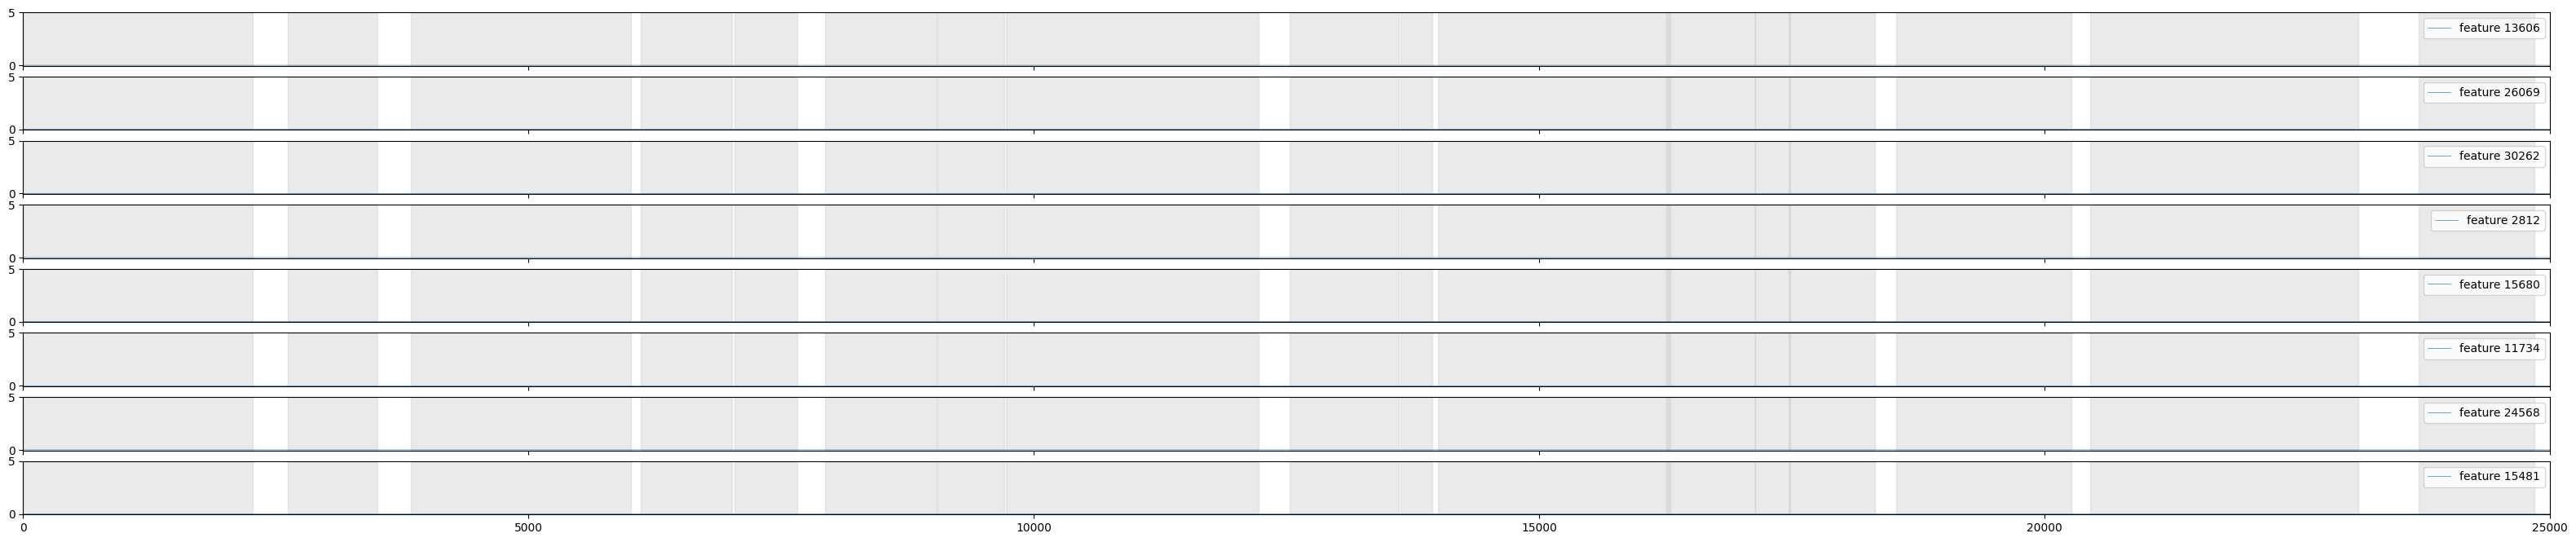

In [12]:
import gc
gc.collect()
torch.mps.empty_cache()

# Get features and plot over a 100kb chunk of the E. coli str. K-12 substr. MG1655 genome, recreating part of the main and supplementary figures
# Download from NCBI: https://www.ncbi.nlm.nih.gov/nuccore/556503834
genbank_file_path = './NC_000913.gb'
start_pos = 4130000
end_pos = start_pos + 25000
# end_pos = 4230000
selected_features = [13606, 26069, 30262, 2812, 15680, 11734, 24568, 15481]

# Load GenBank and get features
records = list(SeqIO.parse(genbank_file_path, "genbank"))
sequence = extract_sequence(genbank_file_path, start_pos, end_pos)
annotations = find_relevant_gb_annotations(records, start_pos, end_pos - start_pos)
# feature_ts = get_feature_ts(topk_sae, sequence)
feature_ts = get_feature_ts_via_forward(topk_sae, sequence, layer_name=SAE_LAYER_NAME)

# Plot selected features with genbank annotations visualized as well
fig, axes = plt.subplots(len(selected_features), 1,  figsize=(40, len(selected_features)), sharex=True)
for i, feature_id in enumerate(selected_features):
    axes[i].plot(feature_ts[:, feature_id], lw=0.5, label=f"feature {feature_id}", alpha=0.9)
    for start, end, feature_type, _ in annotations:
        axes[i].axvspan(start, end, color=ANNOTATION_COLORS.get(feature_type, 'black'), alpha=0.2)
    axes[i].set_xlim(0, feature_ts.shape[0])
    axes[i].set_yticks([0, 5])
    axes[i].legend()
plt.show()